## Hotel Booking Cancellation

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

#### Read Data (hotel_bookings.csv)

In [107]:
source_file = 'hotel_bookings.csv'
data = pd.read_csv(source_file)
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


#### Exploratory Data Analysis

In [108]:
# Clean the Data

data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [109]:
# drop company column since most values are null

data = data.drop(['company'],axis=1)

In [110]:
# drop rows with null values

data = data.dropna(subset = ['agent', 'children', 'country', 'babies'])
data.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

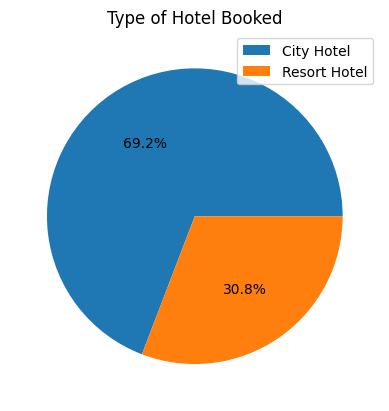

In [111]:
# percent of city and resort hotel stays

hotel_df = data['hotel'].value_counts().rename_axis('Hotel Type').reset_index(name='Frequency')
plt.pie(hotel_df['Frequency'], autopct='%.1f%%')
plt.legend(hotel_df['Hotel Type'])
plt.title("Type of Hotel Booked")
plt.show()

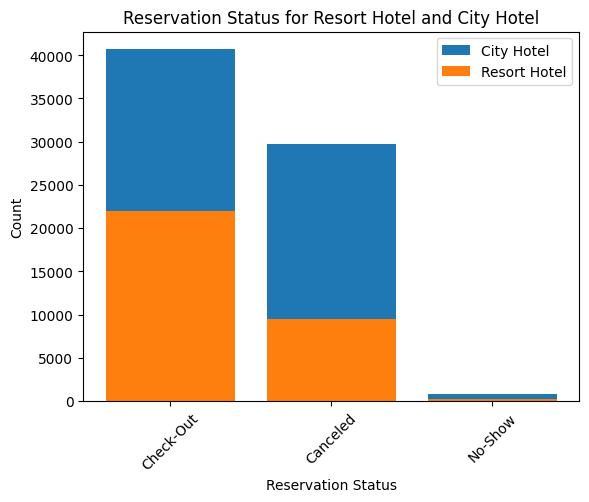

In [112]:
# number of canellations per hotel type

resort_cancel_df = data.loc[data['hotel'] == 'Resort Hotel', 'reservation_status'].value_counts(sort=False).rename_axis('Cancelled').reset_index(name='Frequency')
city_cancel_df = data.loc[data['hotel'] == 'City Hotel', 'reservation_status'].value_counts(sort=False).rename_axis('Cancelled').reset_index(name='Frequency')
plt.bar(city_cancel_df["Cancelled"], city_cancel_df["Frequency"], label = "City Hotel")
plt.bar(resort_cancel_df["Cancelled"], resort_cancel_df["Frequency"], label = "Resort Hotel")
plt.title("Reservation Status for Resort Hotel and City Hotel")
plt.ylabel("Count")
plt.xlabel("Reservation Status")
plt.xticks(rotation = 45)
plt.legend()
plt.show()

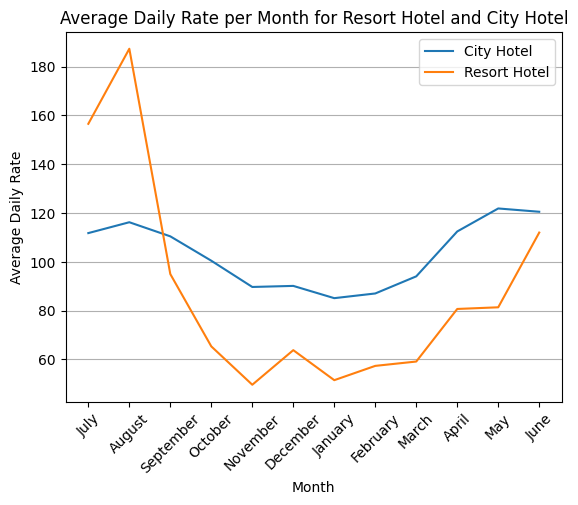

In [113]:
monthly_adr_df = data.groupby(['hotel', 'arrival_date_month'], sort = False)['adr'].mean().reset_index()
resort_monthly_adr_df = monthly_adr_df.loc[monthly_adr_df['hotel'] == 'Resort Hotel']
city_monthly_adr_df = monthly_adr_df.loc[monthly_adr_df['hotel'] == 'City Hotel']
plt.plot(city_monthly_adr_df['arrival_date_month'], city_monthly_adr_df['adr'], label = "City Hotel")
plt.plot(resort_monthly_adr_df['arrival_date_month'], resort_monthly_adr_df['adr'], label = "Resort Hotel")
plt.title("Average Daily Rate per Month for Resort Hotel and City Hotel")
plt.ylabel("Average Daily Rate")
plt.xlabel("Month")
plt.xticks(rotation = 45)
plt.legend()
plt.grid(axis='y', linestyle='-')
plt.show()

In [114]:
#label encoder categorical values
le = preprocessing.LabelEncoder()
data['hotel'] = le.fit_transform(data['hotel'])
data['arrival_date_month'] = le.fit_transform(data['arrival_date_month'])
data['meal'] = le.fit_transform(data['meal'])
data['country'] = le.fit_transform(data['country'])
data['market_segment'] = le.fit_transform(data['market_segment'])
data['distribution_channel'] = le.fit_transform(data['distribution_channel'])
data['reserved_room_type'] = le.fit_transform(data['reserved_room_type'])
data['assigned_room_type'] = le.fit_transform(data['assigned_room_type'])
data['deposit_type'] = le.fit_transform(data['deposit_type'])
data['customer_type'] = le.fit_transform(data['customer_type'])
data['reservation_status'] = le.fit_transform(data['reservation_status'])
data['reservation_status_date'] = le.fit_transform(data['reservation_status_date'])

C:\Users\Jaron\AppData\Local\Temp\ipykernel_18744\3252554372.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, linewidths=1)


<function matplotlib.pyplot.show(close=None, block=None)>

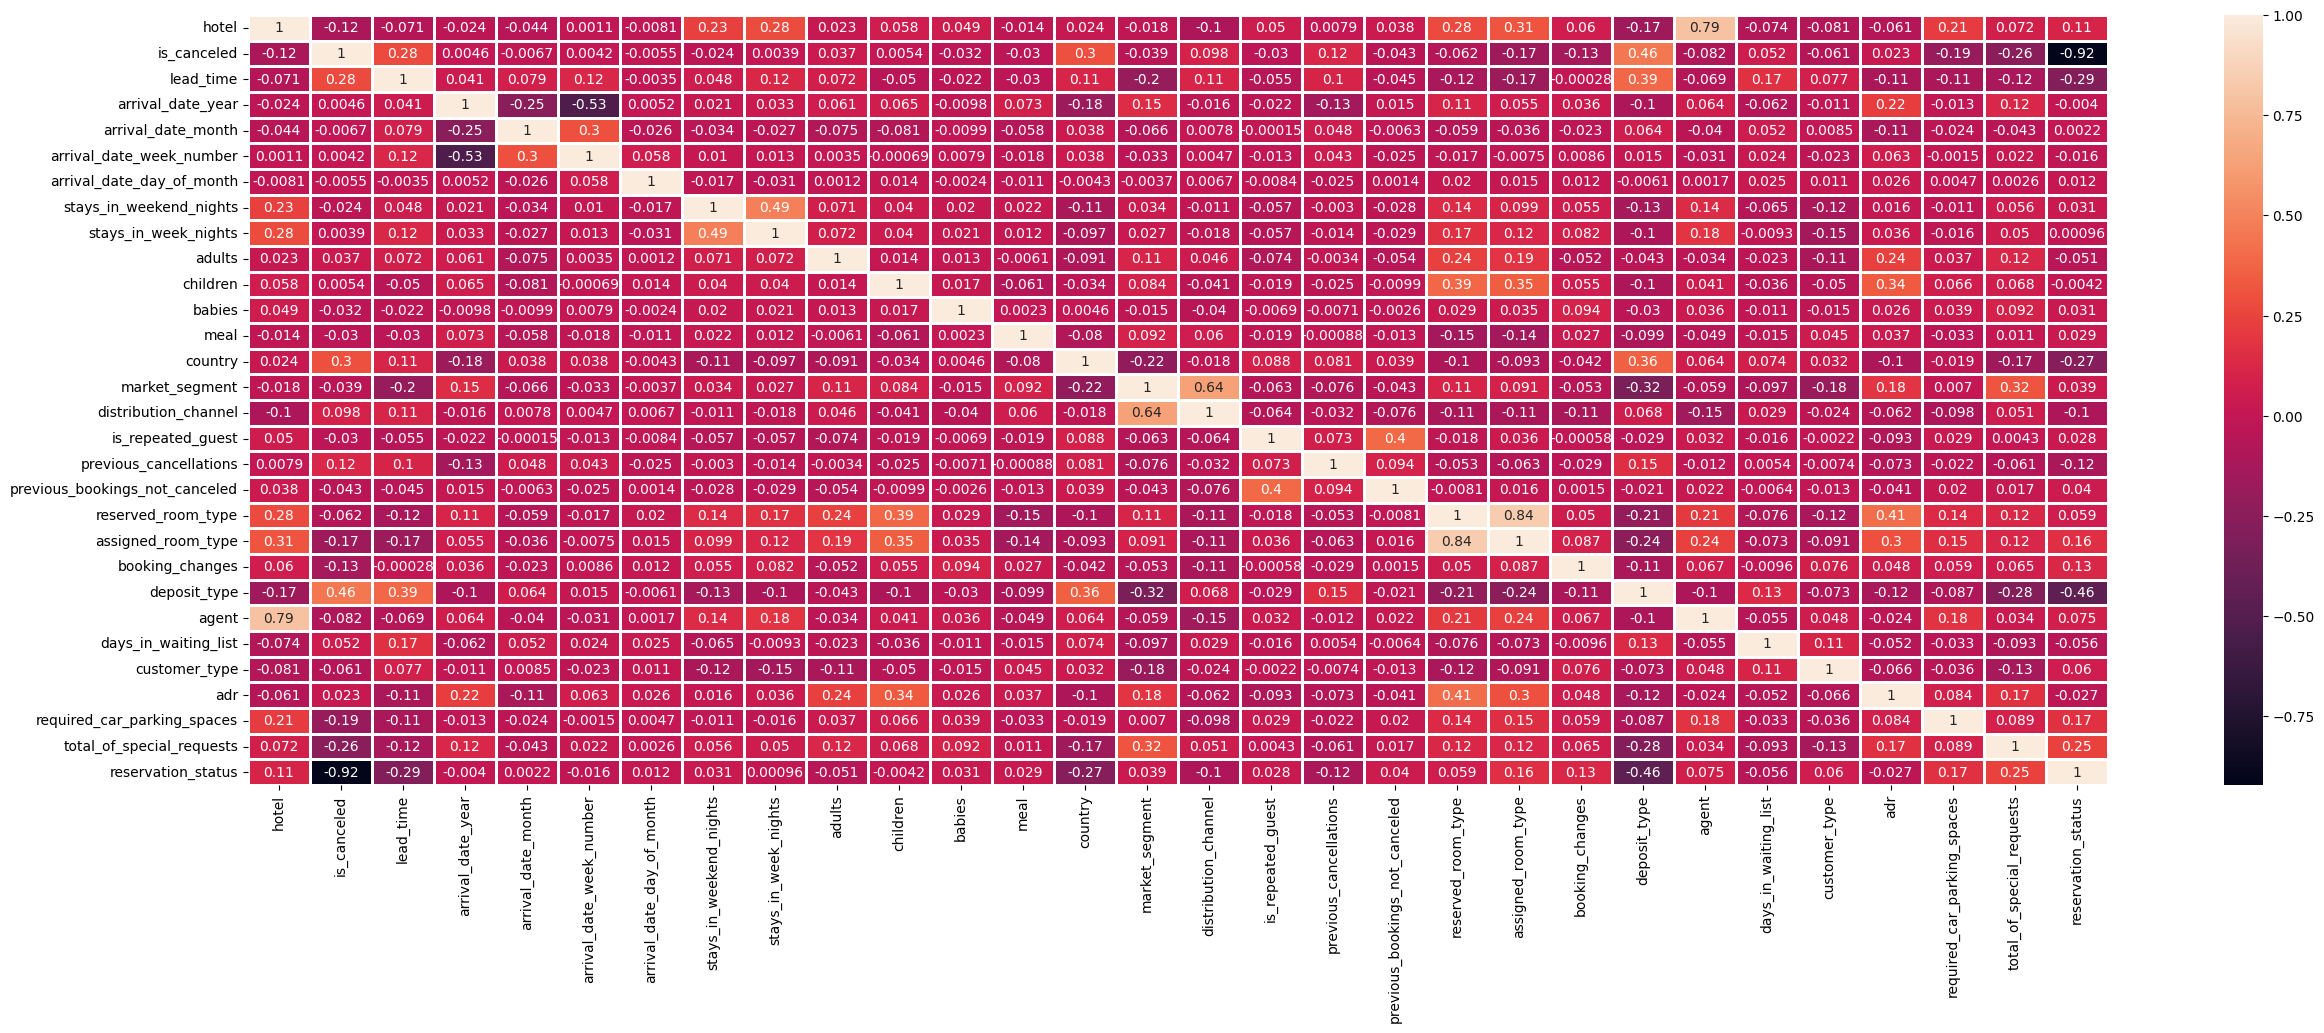

In [101]:
# Correlation Matrix
plt.figure(figsize = (30, 10))
sns.heatmap(data.corr(), annot=True, linewidths=1)
plt.show

In [115]:
# drop reservation_status since it is highly correlated with target label is_cancelled

data = data.drop(['reservation_status'],axis=1)

#### Implementation of Paper 1
- GradientBoost
- Max features = 2, max depth = 2, random state= 0
- default train test split
- evaluated on accuracy, AUROC, F-Measure
- labels -> is_cancelled
- features -> everything else

In [116]:
# labels and features

labels = data.iloc[: , 1]
features = data.loc[:, data.columns != 'is_canceled']

print("Data Shape: ", data.shape)
print("Labels Shape: ", labels.shape)
print("Features Shape: ", features.shape)

Data Shape:  (102894, 30)
Labels Shape:  (102894,)
Features Shape:  (102894, 29)


In [125]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0)
print("Train Shape: ", X_train.shape)
print("Test Shape: ", X_test.shape)

Train Shape:  (77170, 29)
Test Shape:  (25724, 29)


In [119]:
# fit GradientBoost

gb = GradientBoostingClassifier(max_features=2, max_depth=2, random_state=0)
gb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, max_features=2, random_state=0)

In [148]:
# Accuracy, AUROC, F-Measure

acc = gb.score(X_test, y_test)
auroc = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, gb.predict(X_test))
print('Accuracy: ', acc)
print('AUROC: ', auroc)
print('F-Measure: ', f1)

Accuracy:  0.8077670657751516
AUROC:  0.8988980550965044
F-Measure:  0.6988978871095415


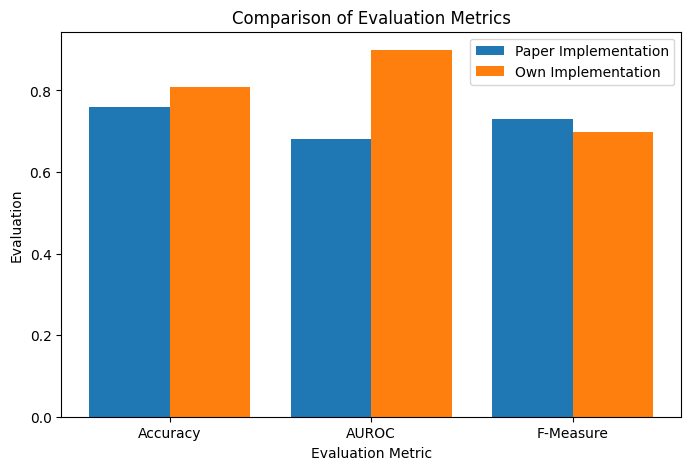

In [166]:
# compare to paper results

x = ['Accuracy','AUROC','F-Measure']
y_paper = [0.76,0.68,0.73]
y_own = [acc,auroc,f1]
  
x_axis = np.arange(len(x))

plt.figure(figsize = (8, 5))

plt.bar(x_axis - 0.2, y_paper, 0.4, label = 'Paper Implementation')
plt.bar(x_axis + 0.2, y_own, 0.4, label = 'Own Implementation')

plt.xticks(x_axis, x)
plt.xlabel("Evaluation Metric")
plt.ylabel("Evaluation")
plt.title("Comparison of Evaluation Metrics")
plt.legend()
plt.show()